In [561]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /content/rockpaperscissors.zip && unzip rockpaperscissors.zip

# delete useless datasets
!rm -rf __MACOSX/ && rm -rf rockpaperscissors/rps-cv-images && rm rockpaperscissors/README_rpc-cv-images.txt

In [563]:
import os

base_dir = 'rockpaperscissors/'
file_name = []
tag = [] 
full_path = []
for path, subdirs, files in os.walk(base_dir):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [564]:
mypath= 'rockpaperscissors/'
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [565]:
import pandas as pd

df = pd.DataFrame({
    "path":full_path,
    'file_name':file_name,
    "tag":tag
})
df.groupby(['tag']).size()

X = df['path']
y = df['tag']

In [566]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.40, random_state =100
)

In [567]:
df_train = pd.DataFrame({
    'path': X_train,
    'tag': y_train,
    'set': 'train'
})

df_val = pd.DataFrame({
    'path': X_val,
    'tag': y_val,
    'set': 'val'
})

In [568]:
df_all = df_train.append([df_val]).reset_index(drop=1)

print(df_all.groupby(['set','tag']).size(),'\n')

set    tag     
train  paper       441
       rock        437
       scissors    434
val    paper       271
       rock        289
       scissors    316
dtype: int64 



In [569]:
import shutil
from tqdm.notebook import tqdm as tq

In [ ]:
datasource_path = base_dir
dataset_path = "rockpaperscissors/dataset/"

for index, row in tq(df_all.iterrows()):
    
    # detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    # make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    # define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    # copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [571]:
train_dir = os.path.join(dataset_path, 'train')
validation_dir = os.path.join(dataset_path, 'val')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    vertical_flip=True,
    shear_range = 0.2,
    zoom_range=0.2,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    vertical_flip=True,
    shear_range = 0.2,
    zoom_range=0.2,
    fill_mode = 'nearest'
)

In [583]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(200, 200),  # 150x150 pixel
        batch_size=4,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(200, 200), # 150x150 pixel
        batch_size=4, 
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [584]:
model = tf.keras.models.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(2,2)),
    # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=(1, 1), input_shape=(2188, 200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=(1, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', strides=(1, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', strides=(1, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, input_dim=20, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [586]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(lr=0.0004),
    metrics=['accuracy']
)

model.fit(
    train_generator,
    steps_per_epoch=25,  
    epochs=10,
    validation_data=validation_generator, 
    validation_steps=len(validation_generator),
    verbose=2,
    shuffle=True
)

# Check accuracy and loss
loss, acc = model.evaluate(validation_generator, batch_size=20)
print("Accuracy : {:5.2f}%".format(100 * acc))
print("Loss : {:.2f}%".format(100 * loss))

Epoch 1/10
25/25 - 44s - loss: 1.0753 - accuracy: 0.4400 - val_loss: 1.0861 - val_accuracy: 0.3242
Epoch 2/10
25/25 - 44s - loss: 0.9228 - accuracy: 0.5500 - val_loss: 0.7964 - val_accuracy: 0.6895
Epoch 3/10
25/25 - 43s - loss: 0.7507 - accuracy: 0.6900 - val_loss: 0.6413 - val_accuracy: 0.7842
Epoch 4/10
25/25 - 43s - loss: 0.6309 - accuracy: 0.7400 - val_loss: 0.5549 - val_accuracy: 0.7831
Epoch 5/10
25/25 - 43s - loss: 0.4135 - accuracy: 0.8300 - val_loss: 0.4312 - val_accuracy: 0.8527
Epoch 6/10
25/25 - 44s - loss: 0.3784 - accuracy: 0.8300 - val_loss: 0.3608 - val_accuracy: 0.8676
Epoch 7/10
25/25 - 43s - loss: 0.3602 - accuracy: 0.8400 - val_loss: 0.2992 - val_accuracy: 0.8984
Epoch 8/10
25/25 - 43s - loss: 0.2942 - accuracy: 0.9100 - val_loss: 0.3103 - val_accuracy: 0.9041
Epoch 9/10
25/25 - 43s - loss: 0.3493 - accuracy: 0.9000 - val_loss: 0.4345 - val_accuracy: 0.8322
Epoch 10/10
25/25 - 43s - loss: 0.3104 - accuracy: 0.8900 - val_loss: 0.2540 - val_accuracy: 0.9064
219/219 [

Saving 6gt1kvpjTKJIA7S0.png to 6gt1kvpjTKJIA7S0.png
6gt1kvpjTKJIA7S0.png
Scissors


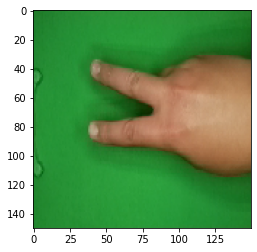

In [582]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  classes = classes.tolist()
  result = classes[0]


  print(fn)
  
  if result[0]==1.0:
    print('Paper')
  elif result[1]==1.0:
    print('Rock')
  elif result[2]==1.0:
    print('Scissors')
  else:
    print('Error')